In [148]:
import json
import os
import re
import spacy
import sys
import time
from collections import defaultdict
from pathlib import Path
from typing import Any, Dict, List

import numpy as np
import matplotlib.pyplot as plt

from keybert import KeyBERT
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sentence_transformers import SentenceTransformer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [149]:
analyzer = SentimentIntensityAnalyzer()
model = SentenceTransformer()
keybert = KeyBERT()

In [150]:
movies = {
    13: "Forrest Gump",
    120: "The Lord of the Rings: The Fellowship of the Ring",
    330: "The Lost World: Jurassic Park",
    480105: "47 Meters Down: Uncaged",
    568: "Apollo 13",
    436270: "Black Adam",
    49013: "Cars 2",
    23483: "Kick-Ass",
    268896: "Pacific Rim: Uprising",
    676: "Pearl Harbor"
}


all_users = None
with open("../test.json", "r") as file:
    all_users = json.load(file)

In [151]:
def get_reviews_by_movie_ids(reviews, movie_ids):
    results = {}

    for _, user_reviews in reviews.items():
        for review_data in user_reviews.values():
            movie_id = review_data["movie_id"]

            if movie_id in movie_ids:
                movie_name = movie_ids[movie_id]

                if movie_name not in results:
                    results[movie_name] = []

                results[movie_name].append(review_data)

    return results

filtered_reviews = get_reviews_by_movie_ids(all_users, movies)
# filtered_reviews

# Create the scores for each movie

In [160]:
def create_movie_final_scores(values_to_leave_out: List[any]=N) -> Dict[str, Dict[str, any]]:
    
    result = {}
    print(f"Rating values to leave out: {values_to_leave_out}")
    
    for movie, reviews in filtered_reviews.items():
        total_rating = 0
        count_of_ratings = 0
        total_compound = 0
        
        for review in reviews:
            
            rating = review.get("rating", None)
            
            # print(f"Movie: {movie}\nReview: {review}\n")
            
            # Sentiment analysis for a whole review
            # Compound score > 0.05: Positive sentiment
            # Compound score < -0.05: Negative sentiment
            # Compound score between -0.05 and 0.05: Neutral sentiment
            sentiment_scores = analyzer.polarity_scores(review["content"])
            sentiment_score = sentiment_scores["compound"]
            # print(f"Review: {review['content']}\nSentiment_scores: {sentiment_scores}")
            # print("-"*150)

            
            if rating in values_to_leave_out:
                continue
            
            total_rating += rating
            count_of_ratings += 1
            total_compound += sentiment_score
            # print(total_rating)
            
        avg_rating = total_rating / count_of_ratings
        avg_compound_score = total_compound / count_of_ratings
        normalized_sentiment = (avg_compound_score + 1) * 5
        rating_norm_sentiment_divided = (avg_rating + normalized_sentiment) / 2
    
        result[movie] = {
            "rating": total_rating,
            "avg_rating": avg_rating,
            "compound_score": total_compound,
            "avg_compound_score": avg_compound_score,
            "normalized_sentiment": normalized_sentiment,
            "rating_norm_sentiment_divided": rating_norm_sentiment_divided
        }
    
    return result

result_without_none_rating_values = create_movie_final_scores(values_to_leave_out=[None])
result_without_1_10_none_rating_values = create_movie_final_scores(values_to_leave_out=[1,10,None])
result_without_2_9_none_rating_values = create_movie_final_scores(values_to_leave_out=[2,9,None])
result_without_1_2_9_10_none_rating_values = create_movie_final_scores(values_to_leave_out=[1,2,9,10,None])

Rating values to leave out: [None]
Rating values to leave out: [1, 10, None]
Rating values to leave out: [2, 9, None]
Rating values to leave out: [1, 2, 9, 10, None]


# Create the plots

In [141]:
def create_plot(result: Dict[str, Dict[str, any]]) -> None:
    movies = list(result.keys())
    avg_ratings = [metrics['avg_rating'] for metrics in result.values()]
    normalized_sentiments = [metrics['normalized_sentiment'] for metrics in result.values()]
    rating_norm_sentiments = [metrics['rating_norm_sentiment_divided'] for metrics in result.values()]
    differences = [metrics["avg_rating"] - metrics["normalized_sentiment"] for metrics in result.values()]

    categories = [
        ("Average Rating", avg_ratings),
        ("Normalized Sentiment", normalized_sentiments),
        ("(Avg Rating + Sentiment) / 2", rating_norm_sentiments),
        ("Difference (Average Rating - Normalized Sentiment)", differences)
    ]
    
    for (title, value) in categories:
    
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.bar(movies, value)
        ax.set_title(title)
        ax.set_ylabel('Values')
        ax.set_xticks(range(len(movies)))
        ax.set_xticklabels(movies, rotation=90)
        ax.set_xlabel('Movies')

        if "Difference" in title:
            ax.axhline(0, color='black', linewidth=1, linestyle='-')
    
        plt.tight_layout()
        plt.show()

# Interpretation of the values:

### Difference (Average Rating - Normalized Sentiment):

- Positive values -> The Average Rating is higher than the Normalized Sentiment. This could indicate 
that the average rating is better than the sentiment or emotional reactions reflected in the reviews.
The movie might have been rated as high quality, although opinions were more mixed or less positive.

- Negative values -> The Normalized Sentiment is higher than the Average Rating. This could mean
that the moods or opinions in the reviews are more positive than the average ratings suggest. 
The film may have been perceived more positively emotionally than the rating indicates.

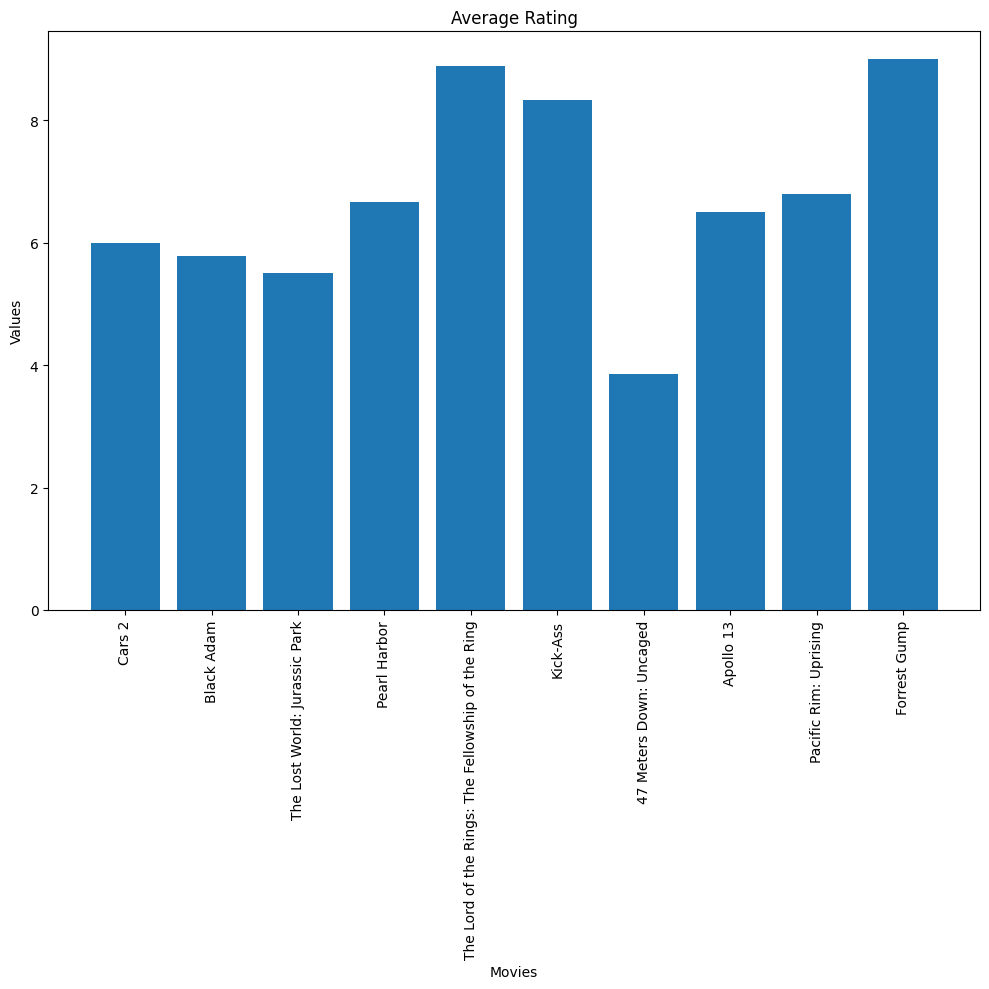

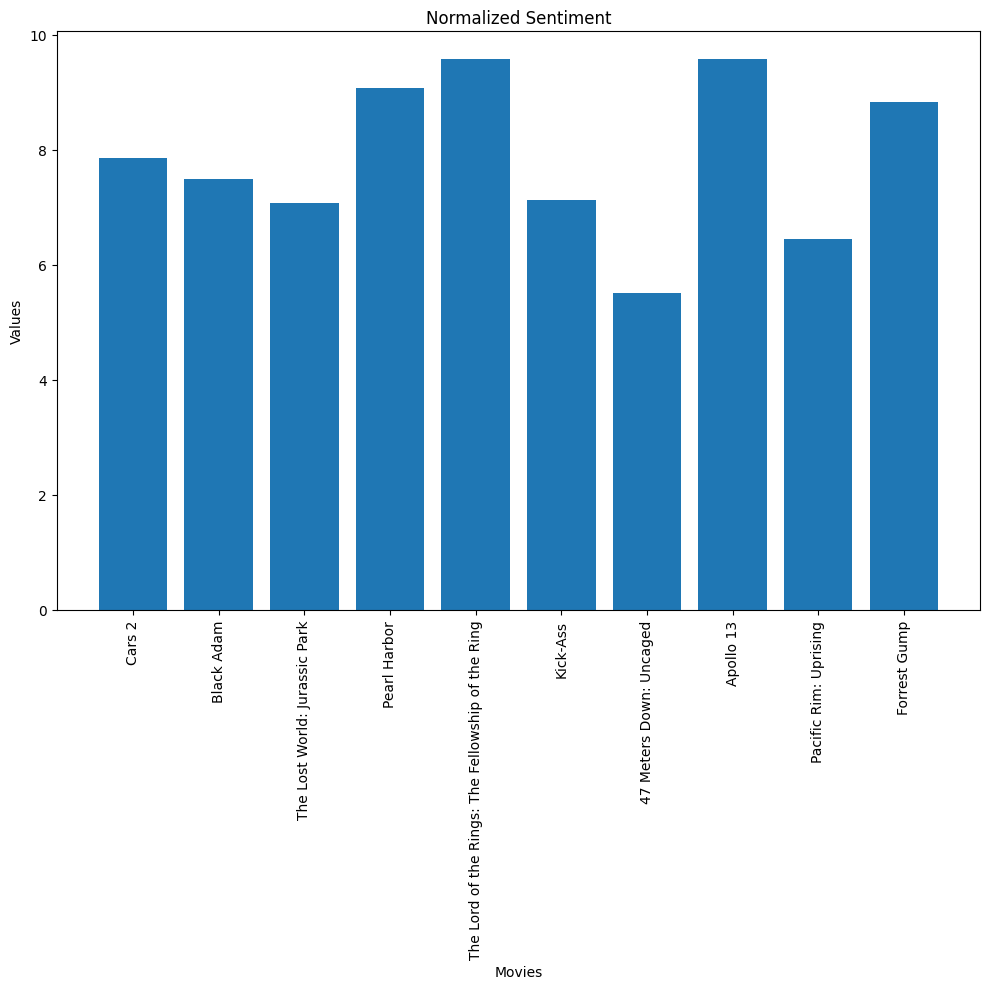

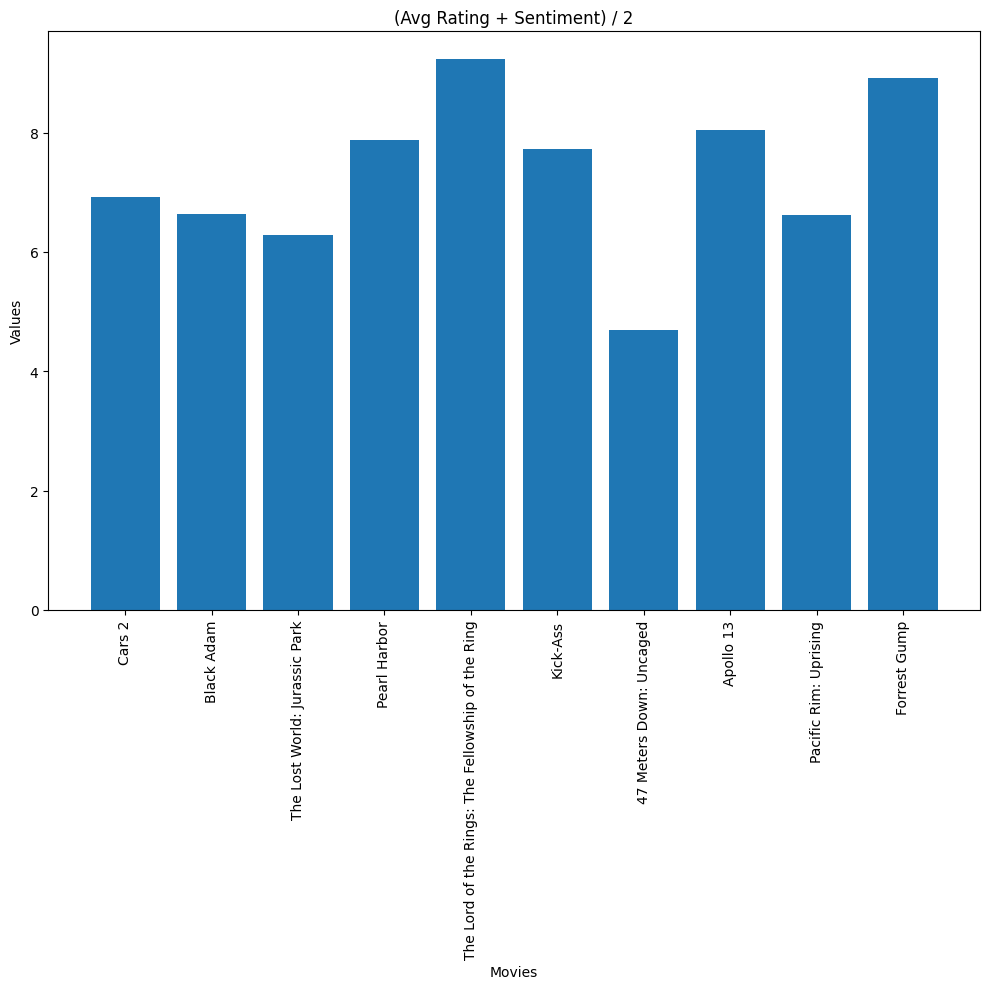

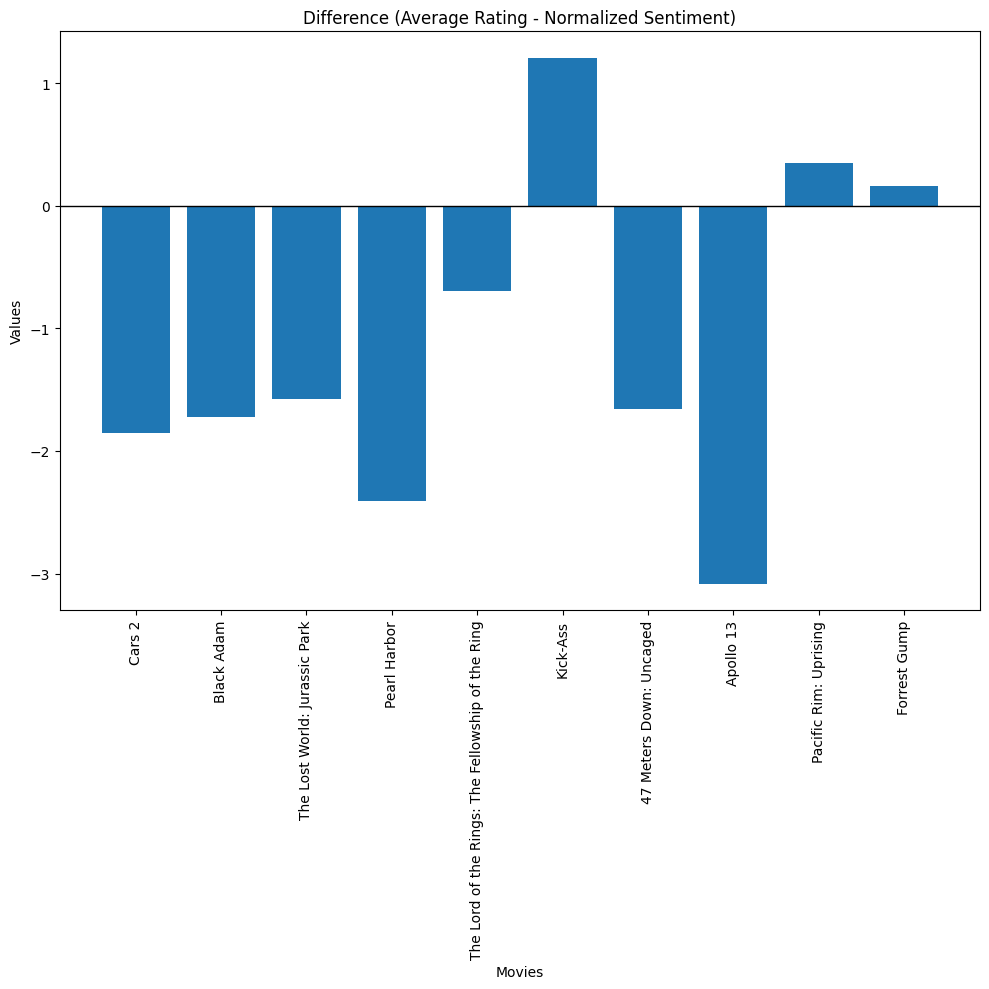

In [142]:
create_plot(result_without_none_rating_values)

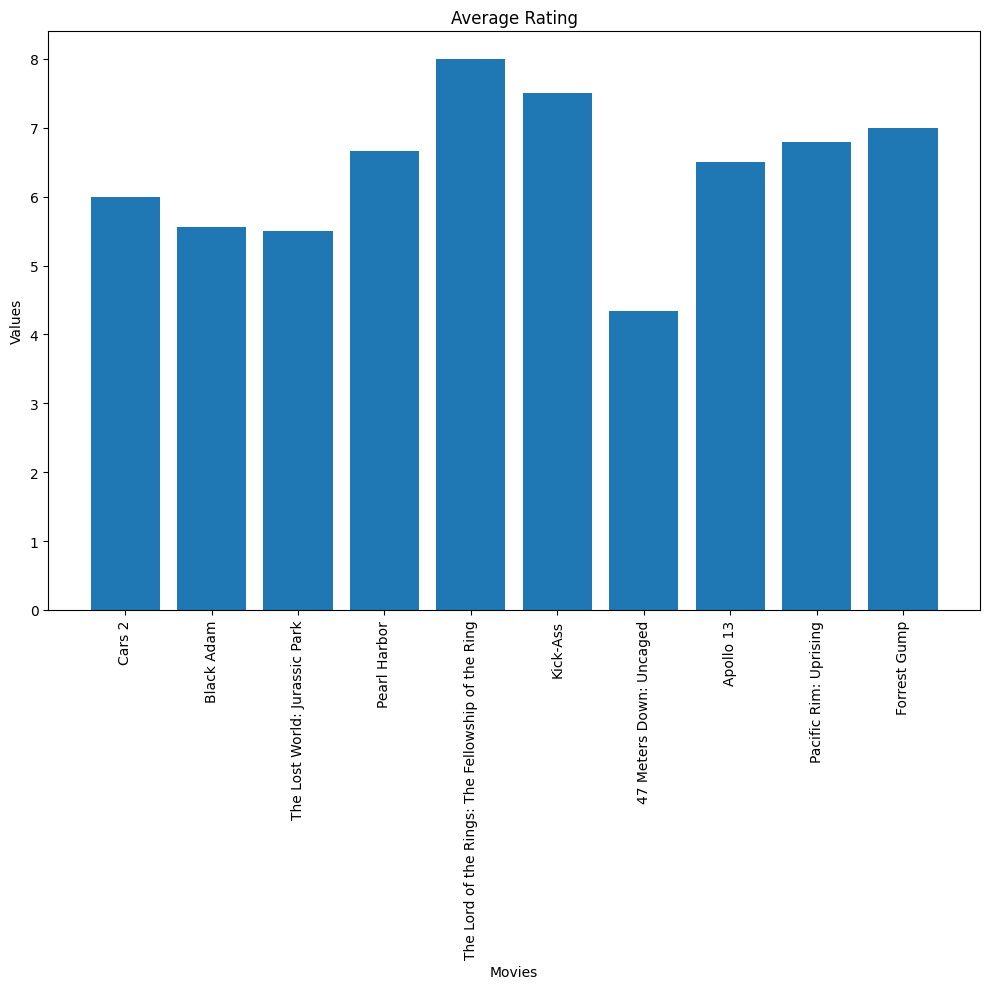

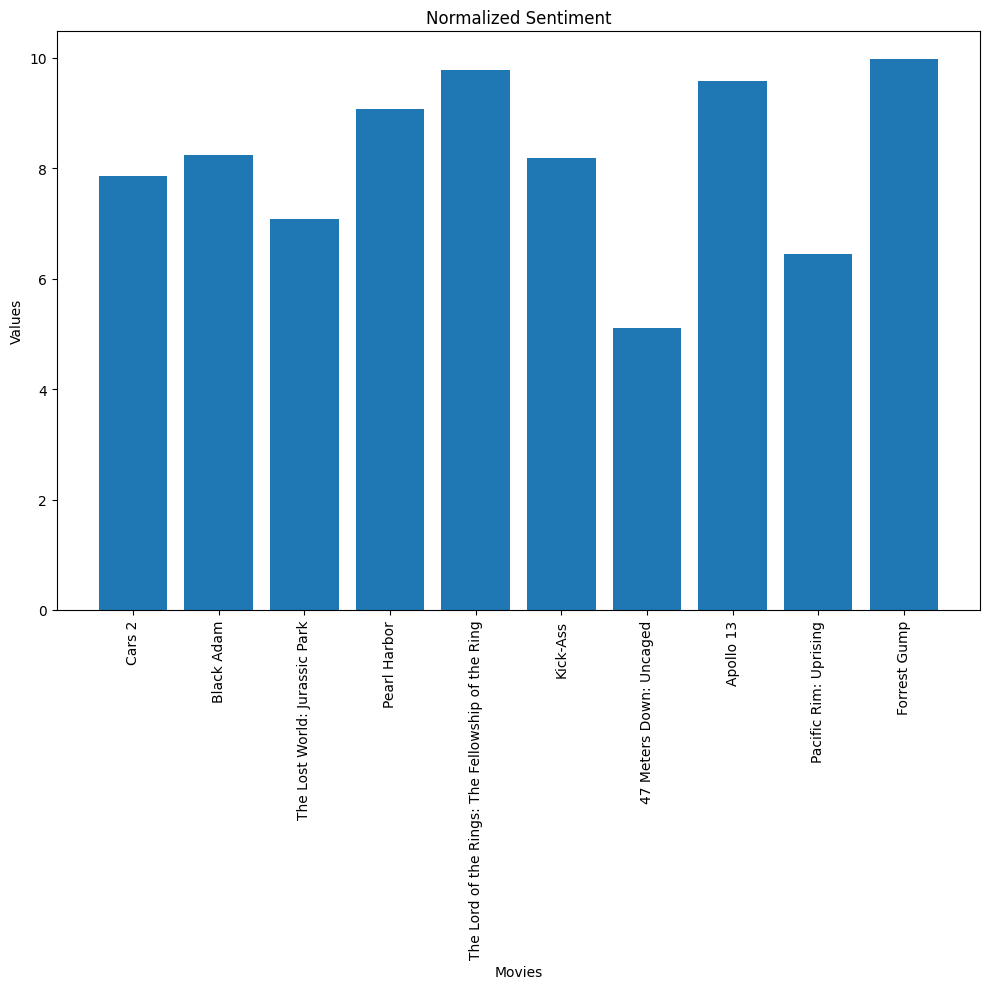

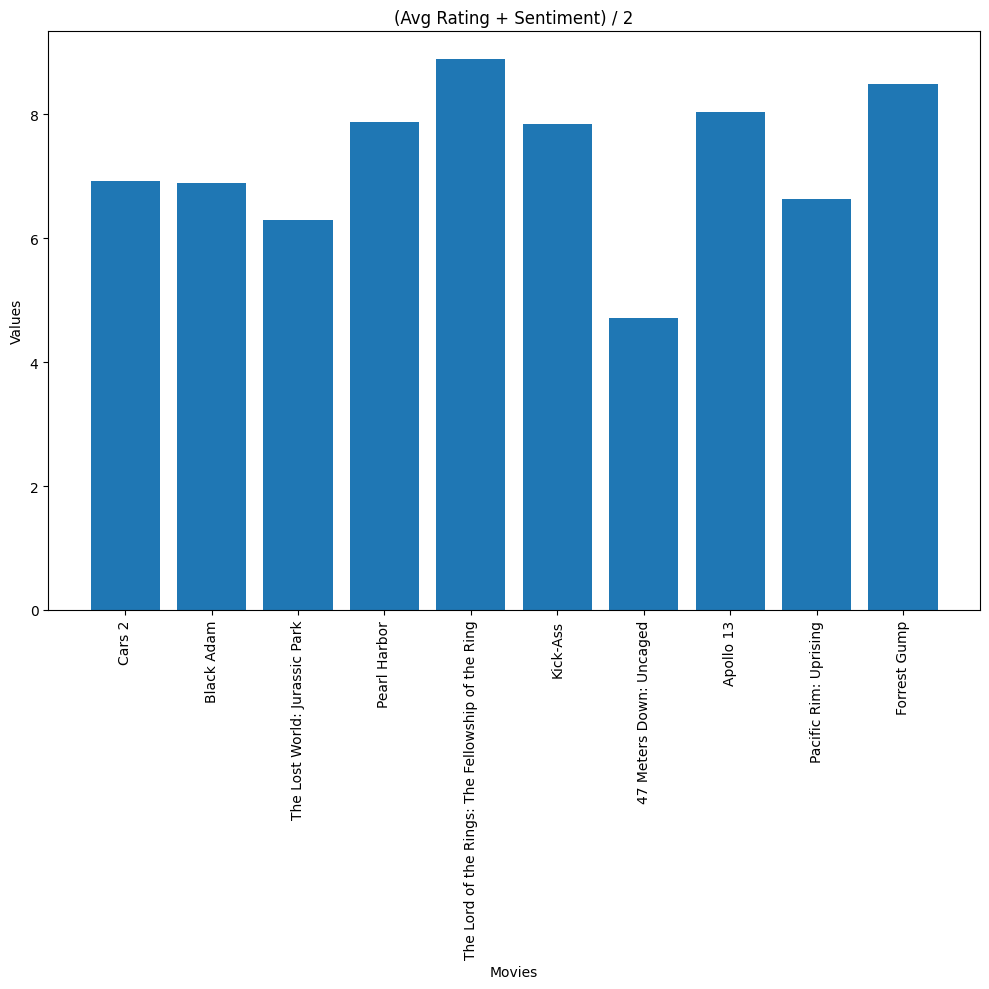

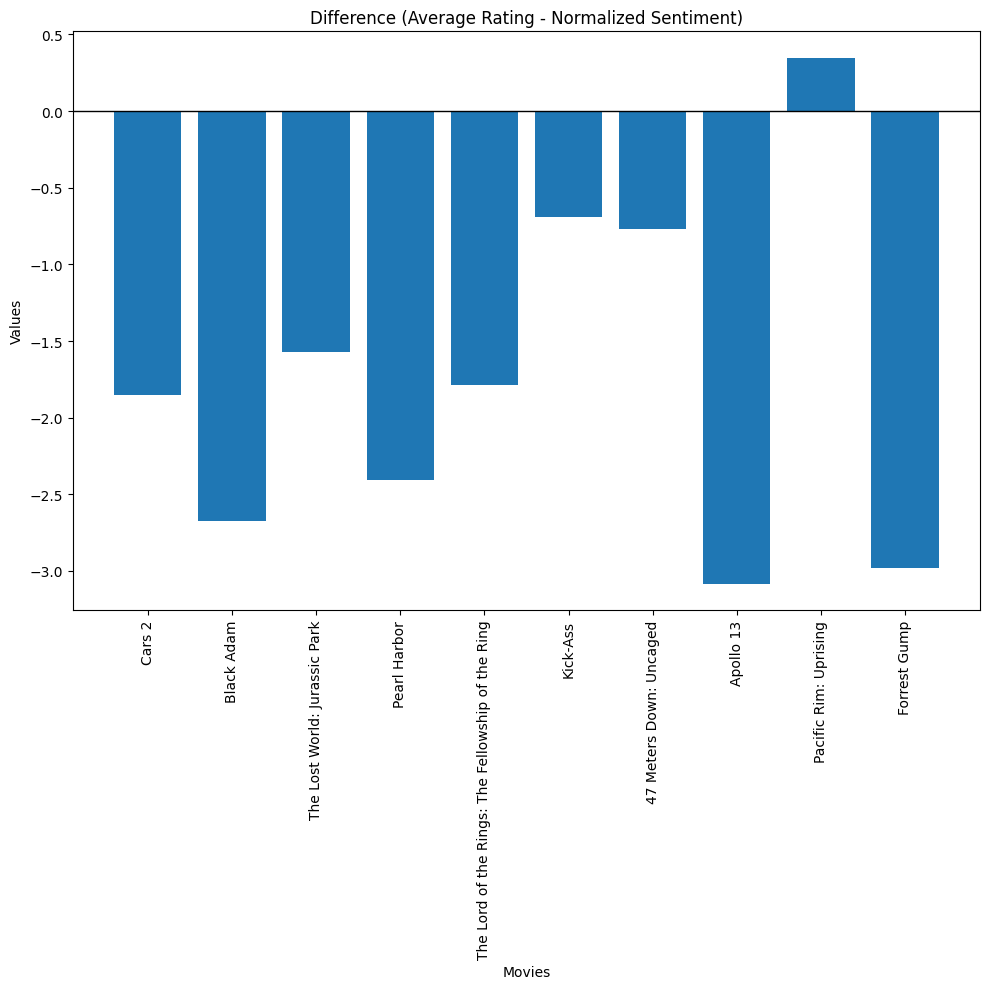

In [143]:
create_plot(result_without_1_10_none_rating_values)

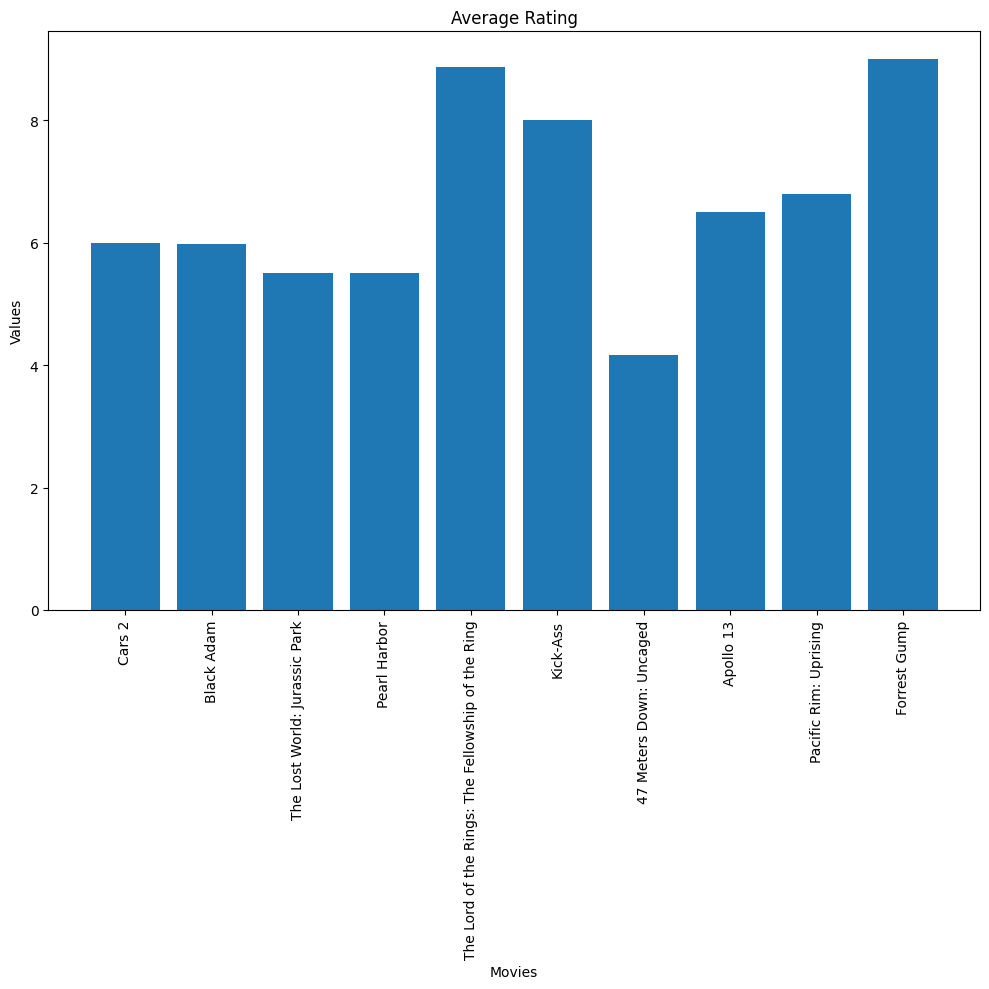

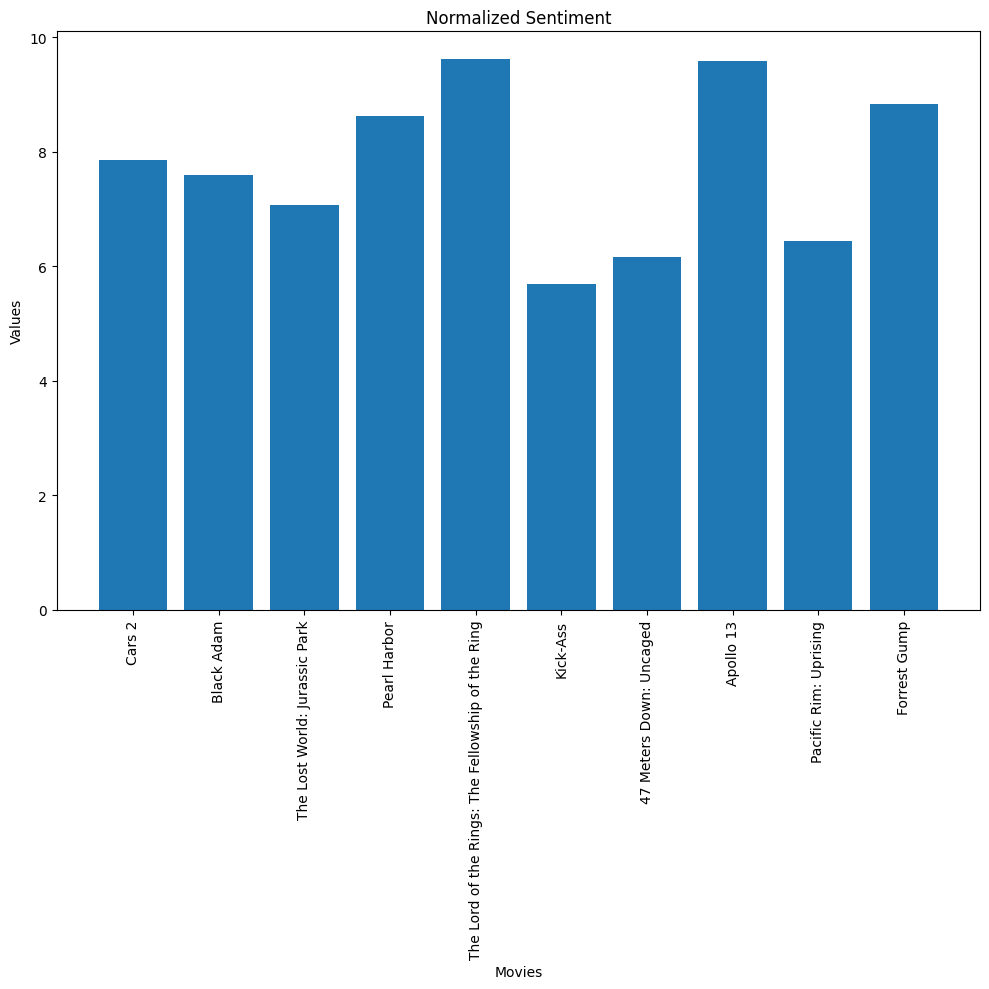

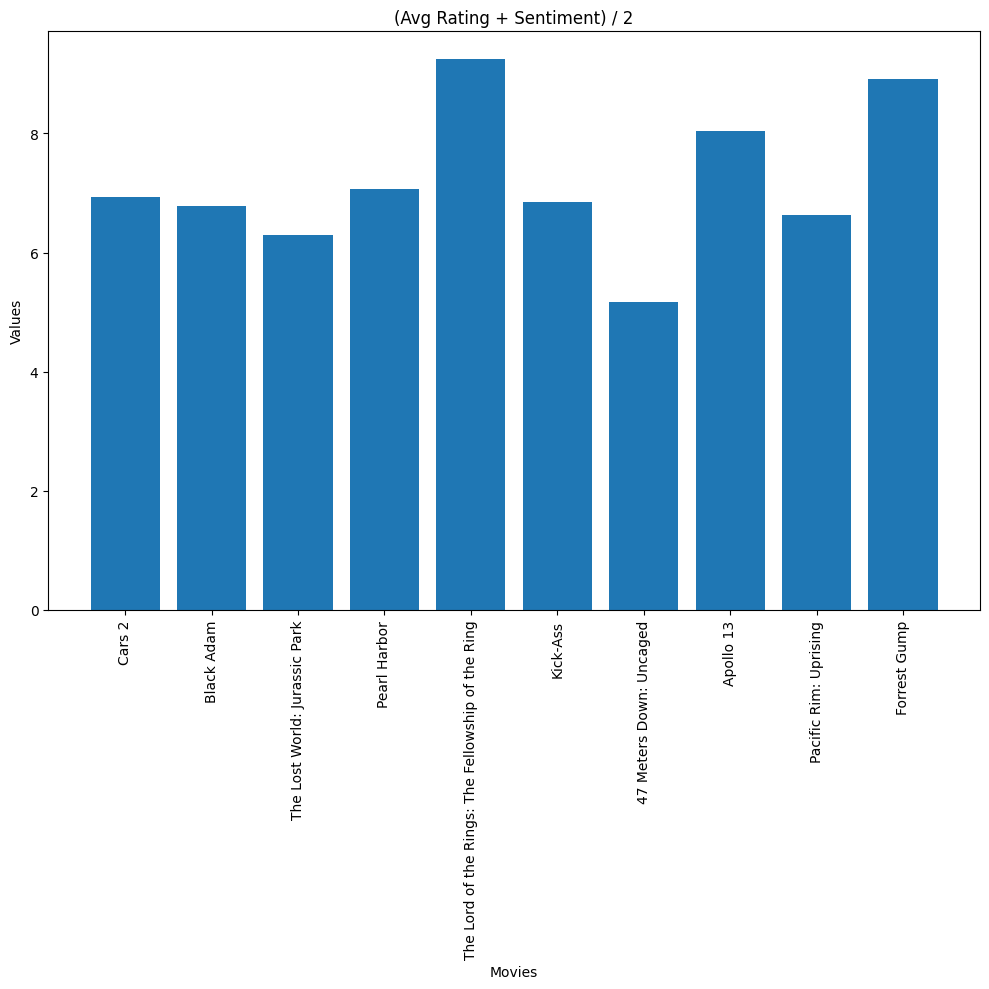

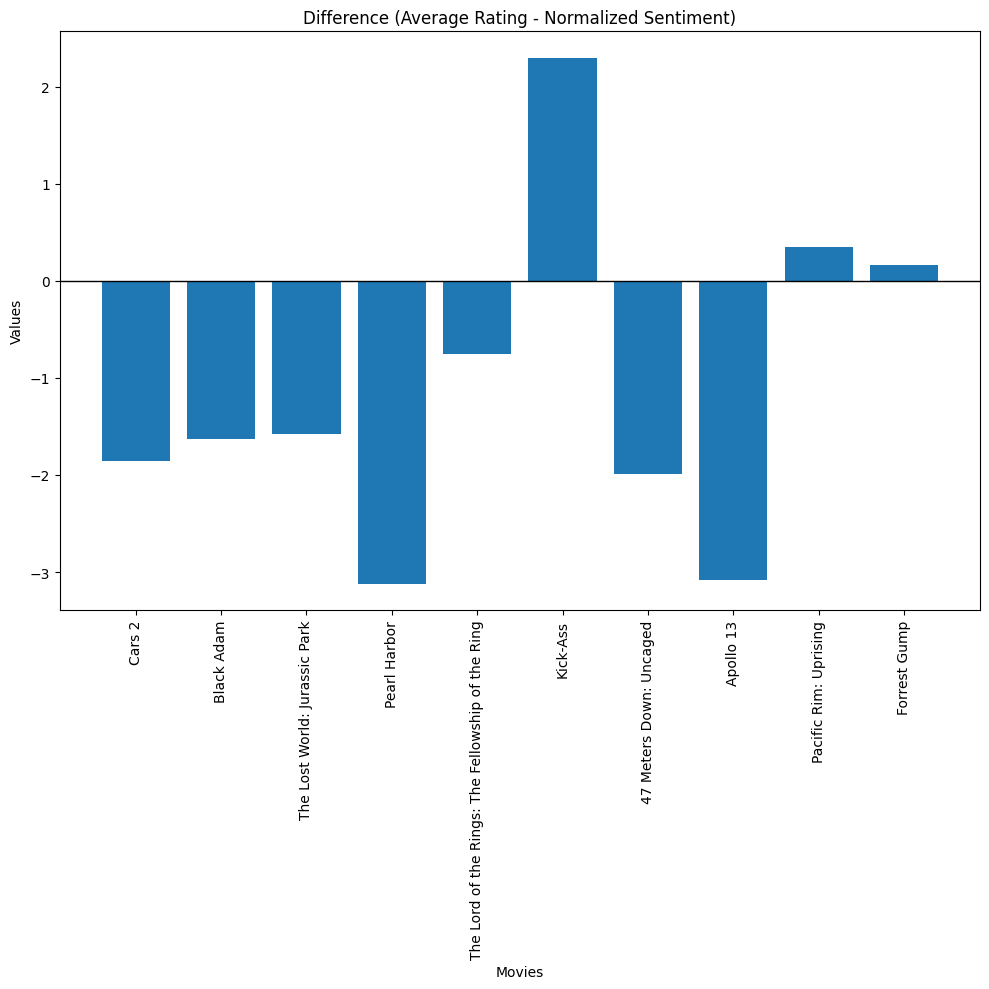

In [144]:
create_plot(result_without_2_9_none_rating_values)

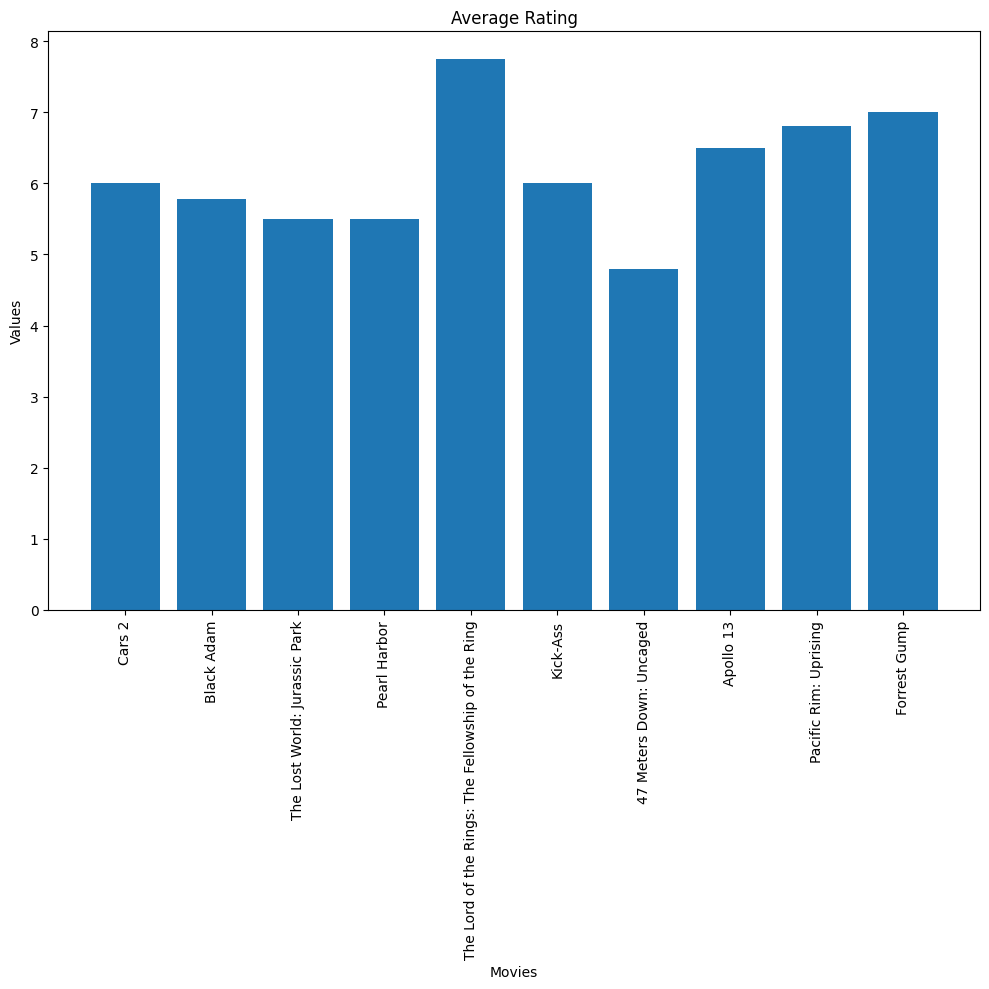

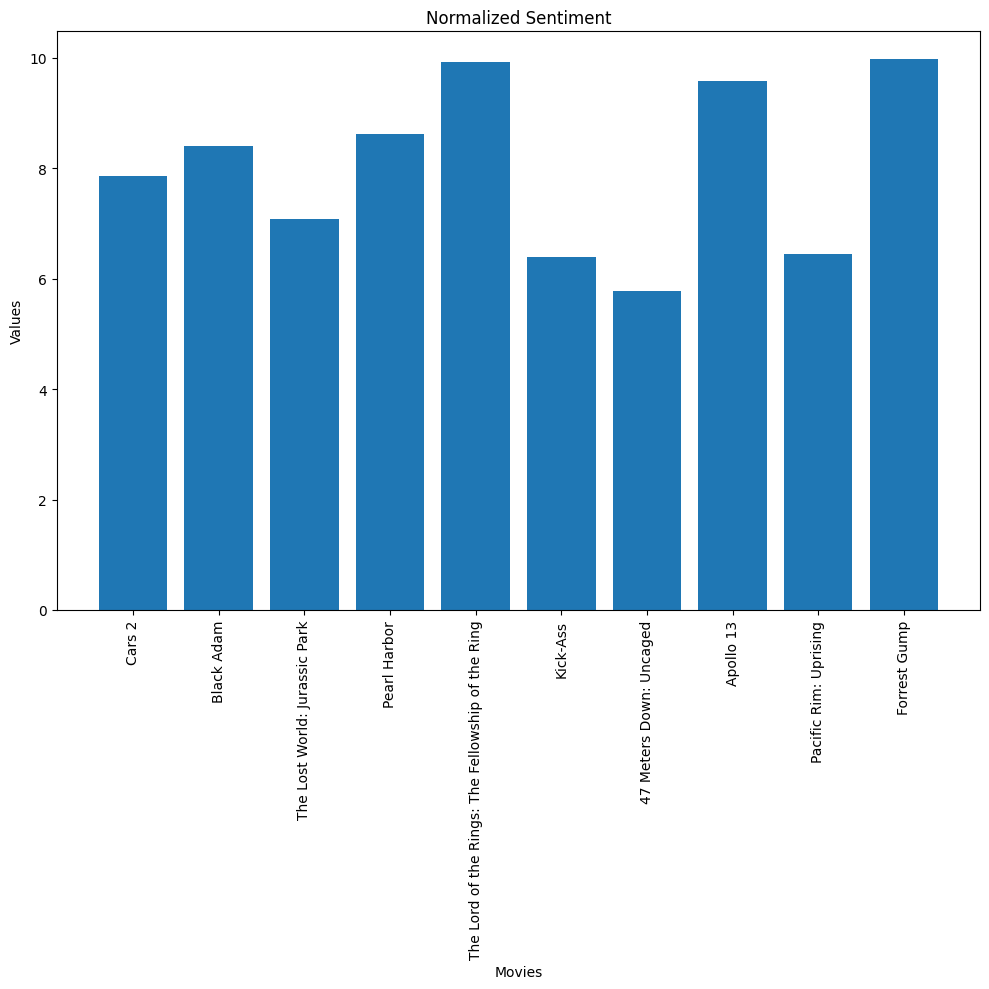

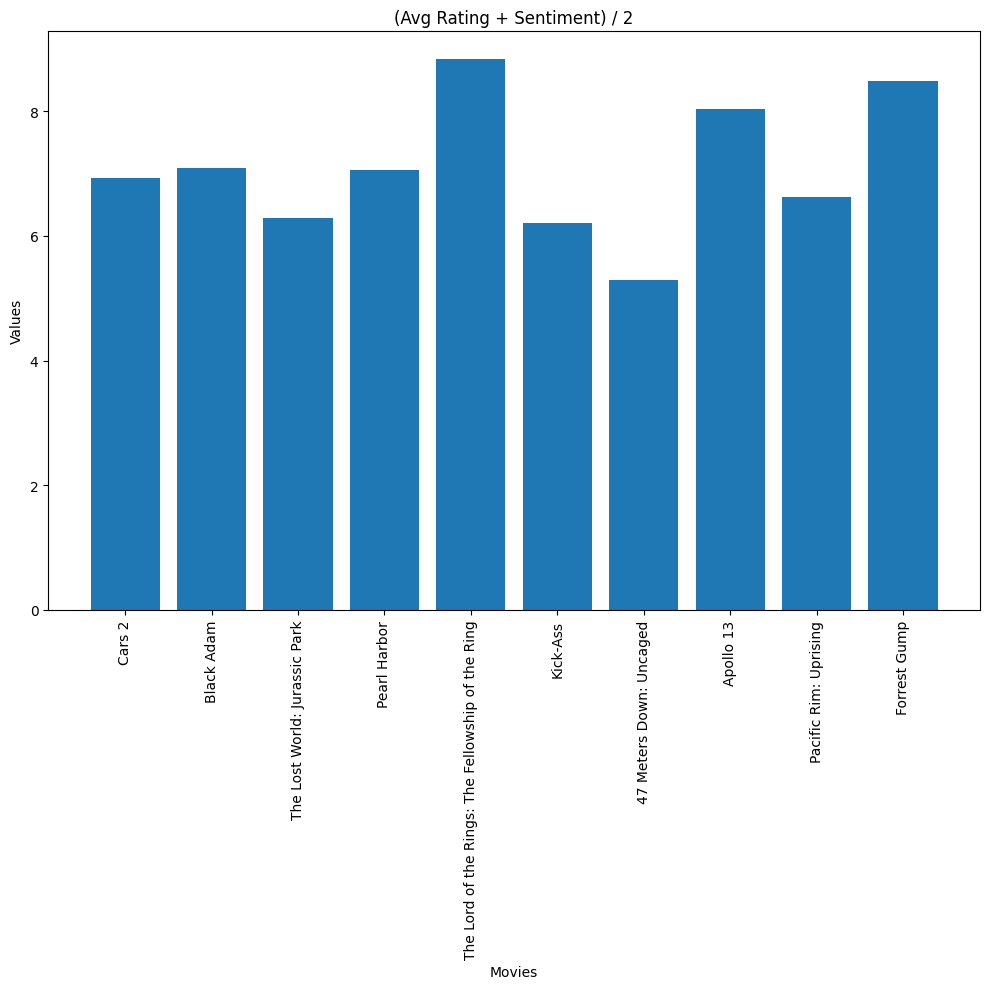

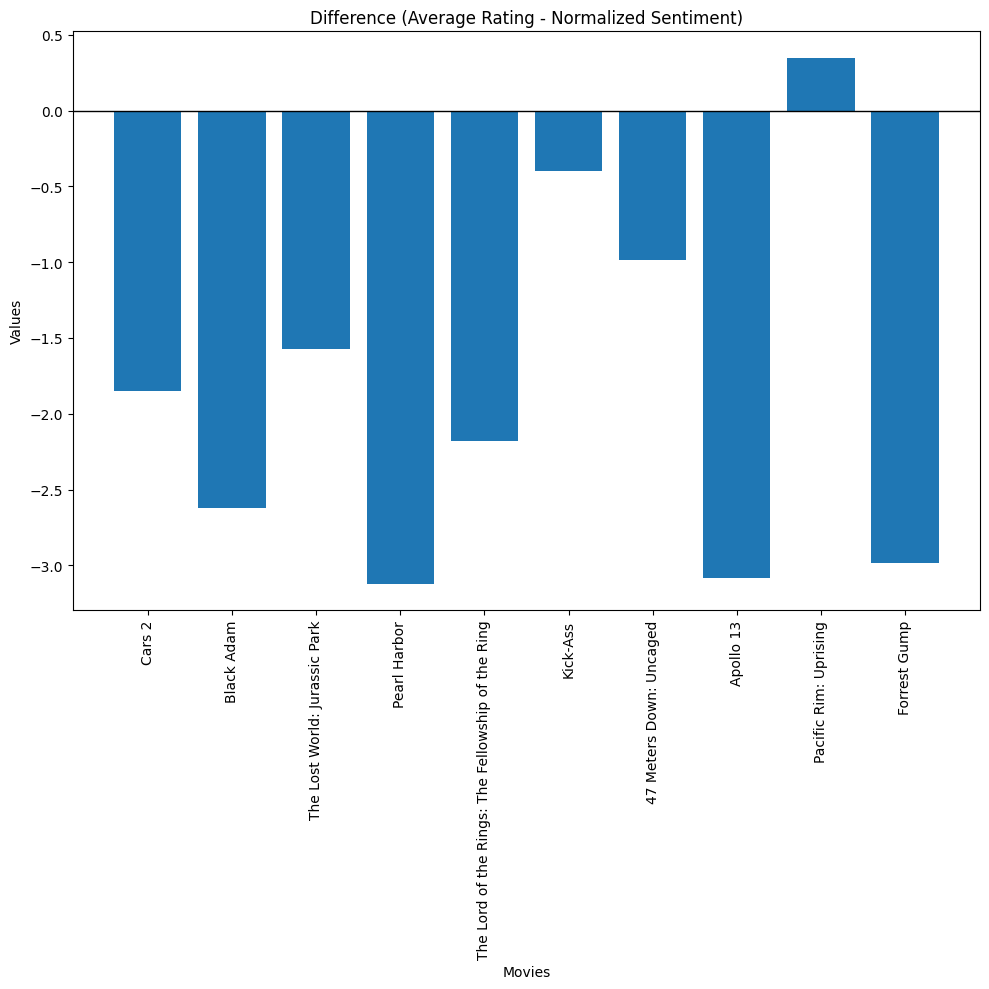

In [145]:
create_plot(result_without_1_2_9_10_none_rating_values)

# Create movie ranking with the different metrics

In [146]:
def create_ranking(result: Dict[str, Dict[str, any]], metric: str) -> None:
    print(f"\nRanking of the movies with the metric: {metric}\n")
 
    sorted_movies = dict(sorted(result.items(), key=lambda x: x[1]['rating_norm_sentiment_divided'], reverse=True))
    for index, (movie, _) in enumerate(sorted_movies.items(), start=1):
        print(f"Rank: {index}, movie: {movie}, score: {result[movie]['rating_norm_sentiment_divided']:.2f}")

In [147]:
create_ranking(result_without_none_rating_values, "Result without none rating values")
create_ranking(result_without_1_10_none_rating_values, "Result without 1,10 and none rating values")
create_ranking(result_without_2_9_none_rating_values, "Result without 2,9 and none rating values")
create_ranking(result_without_1_2_9_10_none_rating_values, "Result without 1,2,9,10 and none rating values")


Ranking of the movies with the metric: Result without none rating values

Rank: 1, movie: The Lord of the Rings: The Fellowship of the Ring, score: 9.23
Rank: 2, movie: Forrest Gump, score: 8.92
Rank: 3, movie: Apollo 13, score: 8.04
Rank: 4, movie: Pearl Harbor, score: 7.87
Rank: 5, movie: Kick-Ass, score: 7.73
Rank: 6, movie: Cars 2, score: 6.93
Rank: 7, movie: Black Adam, score: 6.64
Rank: 8, movie: Pacific Rim: Uprising, score: 6.63
Rank: 9, movie: The Lost World: Jurassic Park, score: 6.29
Rank: 10, movie: 47 Meters Down: Uncaged, score: 4.69

Ranking of the movies with the metric: Result without 1,10 and none rating values

Rank: 1, movie: The Lord of the Rings: The Fellowship of the Ring, score: 8.89
Rank: 2, movie: Forrest Gump, score: 8.49
Rank: 3, movie: Apollo 13, score: 8.04
Rank: 4, movie: Pearl Harbor, score: 7.87
Rank: 5, movie: Kick-Ass, score: 7.84
Rank: 6, movie: Cars 2, score: 6.93
Rank: 7, movie: Black Adam, score: 6.90
Rank: 8, movie: Pacific Rim: Uprising, score: